# 1️⃣ Multiclass Logistic Regression for Diabetes Classification

This section demonstrates **training a Multiclass Logistic Regression model** to predict diabetes status:
- 0 → Non-diabetic
- 1 → Pre-diabetic
- 2 → Diabetic

The pipeline includes **train-test split, SMOTE for class balancing, feature scaling, model training, evaluation, and hyperparameter tuning**.

In [1]:
# ----------------------------
# 1.1 Load Preprocessing Notebook
# ----------------------------
%run ./Preprocessing.ipynb


Preprocessed data saved as joblib files!


# 1.2 Target & Feature Selection

- Target variable: `Class`  
- Selected clinical features:
  - HbA1c
  - BMI
  - AGE
  - Urea
  - Cholesterol (Chol)
  - VLDL
  - Triglycerides (TG)
  - Creatinine (Cr)
  - LDL

In [2]:
# ----------------------------
# 1.2 Target & Selected Features
# ----------------------------
y = df["Class"]
selected_features = ['HbA1c','BMI','AGE','Urea','Chol','VLDL','TG','Cr','LDL']
X = df[selected_features]

# 1.3 Train/Test Split (80/20)

- Split dataset while **maintaining class proportions** using `stratify=y`.

In [3]:
# ----------------------------
# 1.3 Train/Test Split
# ----------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# 1.4 Apply SMOTE for Class Balancing

- Synthetic Minority Oversampling Technique (SMOTE) generates new samples for **minority classes** to balance the dataset.

In [4]:
# ----------------------------
# 1.4 Apply SMOTE
# ----------------------------
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


# 1.5 Feature Scaling

- Standardize features using `StandardScaler` for better logistic regression performance.


In [5]:
# ----------------------------
# 1.5 Scale Features
# ----------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


# 1.6 Train Logistic Regression

- Multiclass logistic regression (`multinomial`) is trained on the balanced and scaled dataset.


In [6]:
# ----------------------------
# 1.6 Train Logistic Regression
# ----------------------------
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    random_state=42,
    solver='saga',  # supports multinomial
    max_iter=5000
)
logreg.fit(X_train_res_scaled, y_train_res)


LogisticRegression(max_iter=5000, random_state=42, solver='saga')

# 1.7 Evaluate Model

- **Accuracy** and **classification report** are used for evaluation.
- **Confusion matrix** visualizes prediction performance per class.

Accuracy: 0.9245283018867925

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.86      0.75      0.80         8
           2       0.96      0.96      0.96        26

    accuracy                           0.92        53
   macro avg       0.91      0.89      0.89        53
weighted avg       0.92      0.92      0.92        53



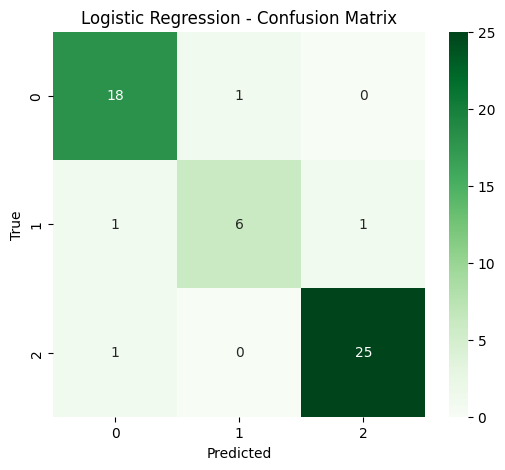

In [7]:
# ----------------------------
# 1.7 Predict & Evaluate
# ----------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 1.8 Hyperparameter Tuning with RandomizedSearchCV

- Optimize **C** (regularization strength), **penalty type**, and **l1_ratio** for elasticnet penalty.
- Metric: `f1_macro` for multiclass performance.
- Use 5-fold cross-validation.

In [9]:
# ----------------------------
# 1.8 Hyperparameter Tuning
# ----------------------------
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1','l2','elasticnet'],
    'l1_ratio': np.linspace(0,1,5)  # only for elasticnet
}

random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(X_train_res_scaled, y_train_res)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=5000, random_state=42,
                                                solver='saga'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=42, scoring='f1_macro', verbose=2)

# 1.9 Best Model Evaluation

- Retrieve **best hyperparameters**.
- Evaluate **accuracy and classification report** on the test set using best estimator.


In [10]:
# ----------------------------
# 1.9 Evaluate Best Model
# ----------------------------
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1_macro Score:", random_search.best_score_)

best_logreg = random_search.best_estimator_
y_pred_best = best_logreg.predict(X_test_scaled)

print("Test Accuracy after Hyperparameter Tuning:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report after Hyperparameter Tuning:\n", classification_report(y_test, y_pred_best))

Best Hyperparameters: {'penalty': 'elasticnet', 'l1_ratio': np.float64(1.0), 'C': np.float64(0.03359818286283781)}
Best F1_macro Score: 0.9506300939921861
Test Accuracy after Hyperparameter Tuning: 0.9433962264150944

Classification Report after Hyperparameter Tuning:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.75      0.86         8
           2       0.93      0.96      0.94        26

    accuracy                           0.94        53
   macro avg       0.96      0.90      0.92        53
weighted avg       0.95      0.94      0.94        53

